In [2]:
import pandas as pd
import numpy as np
import itertools
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from geostatsmodels import utilities, variograms, model, kriging, geoplot
%matplotlib inline

In [3]:
for year in range(2003,2017):
    data = pd.read_csv('data/%d.csv' % (year,))
    data = data[data.Shot!=1]
    if year==2003:
        df = data.loc[0:2,:]
    df = df.append(data.iloc[np.random.choice(range(len(data)),size=75000,replace=False)])

/Users/adamlevin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
def convert_cats(cat):
    if cat in ['Green Side Bunker','Fairway Bunker']:
        return 'Bunker'
    elif cat not in ['Green','Fairway','Fringe','Primary Rough','Intermediate Rough']:
        return 'Other'
    else:
        return cat

In [4]:
if 'Cat' in df.columns:
    df = df.drop('Cat',axis=1)
df.insert(len(df.columns),'Cat',[convert_cats(c) for c in df['From_Location(Scorer)'].tolist()])

In [5]:
y = df.Shots_taken_from_location.values
x1 = np.transpose(np.matrix(df.Distance_from_hole.values))
x2 = pd.get_dummies(df.Cat)
X = np.array(np.multiply(x2.values,x1))

In [6]:
x2.columns

Index([u'Bunker', u'Fairway', u'Fringe', u'Green', u'Intermediate Rough',
       u'Other', u'Primary Rough'],
      dtype='object')

In [7]:
Distance_Models = {}
for u,c in enumerate(x2.columns.tolist()):
    y = df.Shots_taken_from_location.values[np.where(X[:,u]!=0)]
    x = X[np.where(X[:,u]!=0)][:,u]
    Distance_Models[c] = IsotonicRegression(out_of_bounds='clip')
    Distance_Models[c].fit(x,y)

In [3]:
data = pd.read_csv('data/2010.csv')

/Users/adamlevin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data['From_Location(Scorer)'].value_counts()

Green                 416019
Tee Box               255561
Fairway               168880
Primary Rough          77780
Green Side Bunker      24136
Intermediate Rough     20836
Fringe                 14697
Fairway Bunker         12138
Native Area             3416
Other                    717
Water                     52
Grass Bunker              26
Name: From_Location(Scorer), dtype: int64

In [23]:
data.head()

,Year,Tourn.#,Player_#,Course_#,Permanent_Tournament_#,Player_First_Name,Player_Last_Name,Round,Tournament_Name,Course_Name,...,Time,Elevation,Shots_taken_from_location,Went_to_X,Went_to_Y,Went_to_Z,Started_at_X,Started_at_Y,Started_at_Z,Distance_from_hole
0,2010,60,6643,5,5,Paul,Goydos,4,AT&T Pebble Beach National Pro-Am,Pebble Beach GL,...,1343,With,9,30.552200,-999.823591,-35.271,582.593547,-1492.573488,NaN,1602.245567
1,2010,420,26289,609,54,Boo,Weekley,1,Viking Classic,Annandale GC,...,1517,With,3,23.212449,-10.740183,-0.509,502.475818,-161.565367,NaN,527.811819
2,2010,370,2106,752,13,Chris,Smith,2,Wyndham Championship,Sedgefield CC,...,752,With,3,-3.872254,96.901435,-8.457,64.200703,710.834142,NaN,713.727475
3,2010,450,20070,775,464,Matt,Bettencourt,2,Frys.com Open,CordeValle GC,...,1003,With,4,-685.903216,-407.562502,18.742,-1475.043075,-739.051176,NaN,1649.832935
4,2010,170,1706,12,12,Davis,Love III,1,Verizon Heritage,Harbour Town GL,...,1112,With,4,-573.800831,-473.423061,-1.292,-1384.879919,-669.353073,NaN,1538.156665


In [26]:
uCRHtps = list(itertools.product(pd.unique(data['Course_#']),pd.unique(data.Round),pd.unique(data.Hole)))

In [317]:
i = uCRHtps[0]
subset  = data[(data['Course_#']==i[0]) & (data.Round==i[1]) & (data.Hole==i[2]) & (data.Shot!=1)]
subset2 = data[(data['Course_#']==i[0]) & (data.Round==i[1]) & (data.Hole==i[2]) & (data.Shots_taken_from_location==1)]

In [30]:
print i

(5, 4, 14)


In [28]:
len(subset)

298

In [29]:
len(subset2)

66

In [45]:
if 'Cat' in subset.columns:
    subset = subset.drop('Cat',axis=1)
subset.insert(len(subset.columns),'Cat',[convert_cats(c) for c in subset['From_Location(Scorer)'].tolist()])
if 'Predicted_shots_from_location_based_on_distance' in subset.columns:
    subset = subset.drop('Predicted_shots_from_location_based_on_distance',axis=1)
subset.insert(len(subset.columns),'Predicted_shots_from_location_based_on_distance',[Distance_Models[row.Cat].predict([row.Distance_from_hole])[0] for u,row in subset.iterrows()])

In [48]:
subset.head(n=20)[['From_Location(Scorer)','Cat','Distance_from_hole','Predicted_shots_from_location_based_on_distance','Shots_taken_from_location']]

,From_Location(Scorer),Cat,Distance_from_hole,Predicted_shots_from_location_based_on_distance,Shots_taken_from_location
424606,Primary Rough,Primary Rough,913.035058,3.934321,5
426150,Fairway,Fairway,927.042819,3.778601,6
426218,Fairway,Fairway,952.007768,3.825770,6
426251,Fairway,Fairway,1000.290283,3.889186,8
426254,Fairway,Fairway,914.444340,3.778601,8
426255,Fairway,Fairway,942.138305,3.824281,8
426256,Primary Rough,Primary Rough,852.128340,3.845789,8
426480,Fairway,Fairway,929.179740,3.779468,6
426555,Intermediate Rough,Intermediate Rough,992.409535,3.902655,6
426656,Primary Rough,Primary Rough,1015.884683,4.092593,6


In [49]:
if 'Residuals' in subset.columns:
    subset = subset.drop('Residuals',axis=1)
subset.insert(len(subset.columns),'Residuals',subset.Shots_taken_from_location.values - subset.Predicted_shots_from_location_based_on_distance)

In [50]:
np.corrcoef(subset.Residuals.values,subset.Distance_from_hole.values)

array([[ 1.        ,  0.14924793],
       [ 0.14924793,  1.        ]])

In [51]:
xyz = pd.DataFrame({'x':subset.Started_at_X.values,'y':subset.Started_at_Y.values,'z':subset.Residuals.values})

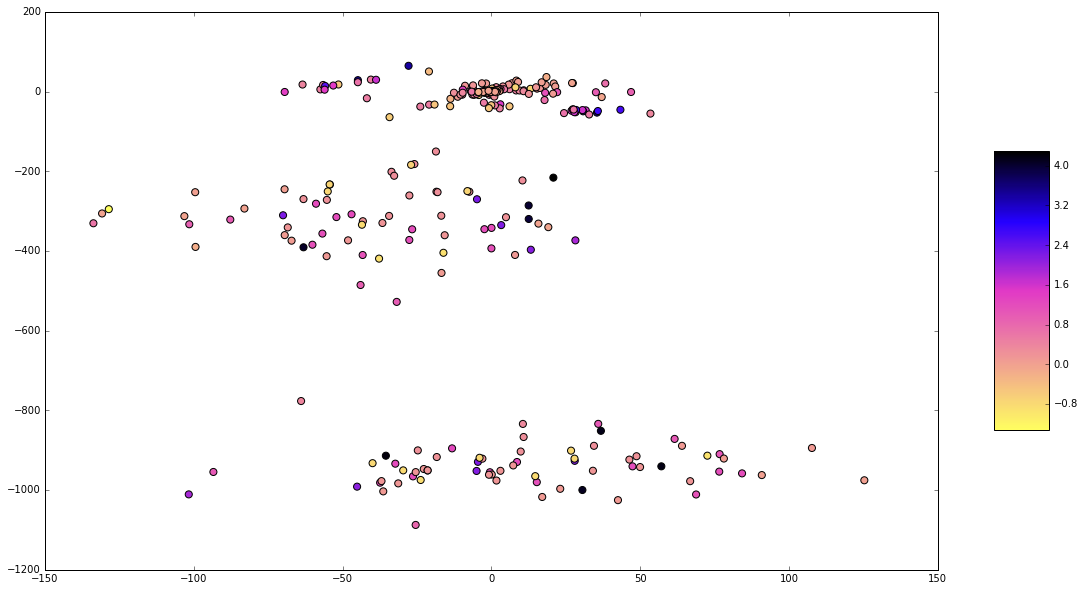

In [60]:
fig,ax = plt.subplots(figsize=(20, 10))
geo = geoplot.scatter( xyz.x, xyz.y, c=xyz.z, cmap=geoplot.YPcmap,s=50 )
fig.colorbar(geo, shrink=0.5, aspect=5)

In [158]:
tolerance = 50
lags = np.arange( tolerance, 1000, tolerance*2 )
sill = np.var(xyz.z)

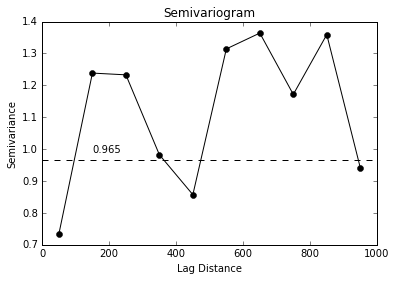

In [159]:
geoplot.semivariogram( xyz.values, lags, tolerance )

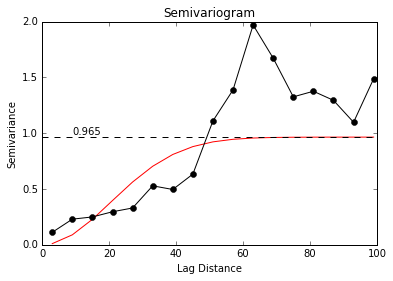

In [73]:
svm = model.semivariance( model.gaussian, ( 50, sill ) )
geoplot.semivariogram( xyz.values, lags, tolerance, model=svm )

In [134]:
covfct = model.covariance( model.gaussian, ( 50, sill ) )

In [135]:
kriging.simple( xyz.values, covfct, [-10,5], N=10 )

(2.07805168687795, 0.43122495268672623)

In [136]:
kriging.ordinary(  xyz.values, covfct, [-10,5], N=10  )

(2.0721069267327343, 0.43122495842690667)

(array([  12.,   24.,  149.,   42.,   39.,    8.,    9.,    3.,    4.,    8.]),
 array([-1.33165829, -0.76948852, -0.20731875,  0.35485102,  0.91702079,
         1.47919056,  2.04136033,  2.6035301 ,  3.16569987,  3.72786964,
         4.29003941]),
 <a list of 10 Patch objects>)

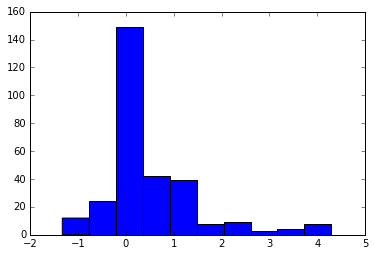

In [77]:
plt.hist(subset.Residuals)

In [305]:
def convert_cats2(cat):
    if cat in ['Green Side Bunker','Fairway Bunker']:
        return 'Bunker'
    elif cat not in ['Green','Fairway','Fringe','Primary Rough','Intermediate Rough'] or cat=='Primary Rough':
        return 'Rough'
    elif cat in ['Fairway','Intermediate Rough','Fringe']:
        return 'Fairway'
    else:
        return cat

In [306]:
if 'Cat2' in subset.columns:
    subset = subset.drop('Cat2',axis=1)
subset.insert(len(subset.columns),'Cat2',[convert_cats2(c) for c in subset['From_Location(Scorer)'].tolist()])
cats = pd.unique(subset.Cat2)

In [307]:
Hole_Specific_Distance_Models = {}
for c in cats:
    y = subset[subset.Cat2==c].Shots_taken_from_location
    x = subset[subset.Cat2==c].Distance_from_hole
    Hole_Specific_Distance_Models[c] = IsotonicRegression(out_of_bounds='clip')
    Hole_Specific_Distance_Models[c].fit(x,y)

In [318]:
Hole_Specific_Distance_Model = IsotonicRegression(out_of_bounds='clip')
Hole_Specific_Distance_Model.fit(subset.Distance_from_hole.values,subset.Shots_taken_from_location.values)

IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
          y_min=None)

In [308]:
if 'Predicted_shots_from_location_based_on_distance2' in subset.columns:
    subset = subset.drop('Predicted_shots_from_location_based_on_distance2',axis=1)
subset.insert(len(subset.columns),'Predicted_shots_from_location_based_on_distance2',[Hole_Specific_Distance_Models[row.Cat2].predict([row.Distance_from_hole])[0] for u,row in subset.iterrows()])

In [320]:
if 'Predicted_shots_from_location_based_on_distance3' in subset.columns:
    subset = subset.drop('Predicted_shots_from_location_based_on_distance2',axis=1)
subset.insert(len(subset.columns),'Predicted_shots_from_location_based_on_distance3',Hole_Specific_Distance_Model.predict(subset.Distance_from_hole.values))

In [309]:
subset[['From_Location(Scorer)','Cat2','Distance_from_hole','Predicted_shots_from_location_based_on_distance2','Shots_taken_from_location']]

,From_Location(Scorer),Cat2,Distance_from_hole,Predicted_shots_from_location_based_on_distance2,Shots_taken_from_location
424606,Primary Rough,Rough,913.035058,4.555556,5
426150,Fairway,Fairway,927.042819,4.464286,6
426218,Fairway,Fairway,952.007768,4.464286,6
426251,Fairway,Fairway,1000.290283,5.000000,8
426254,Fairway,Fairway,914.444340,4.285714,8
426255,Fairway,Fairway,942.138305,4.464286,8
426256,Primary Rough,Rough,852.128340,4.555556,8
426480,Fairway,Fairway,929.179740,4.464286,6
426555,Intermediate Rough,Fairway,992.409535,5.000000,6
426656,Primary Rough,Rough,1015.884683,5.500000,6


In [321]:
subset[['From_Location(Scorer)','Distance_from_hole','Predicted_shots_from_location_based_on_distance3','Shots_taken_from_location']]

,From_Location(Scorer),Distance_from_hole,Predicted_shots_from_location_based_on_distance3,Shots_taken_from_location
424606,Primary Rough,913.035058,4.380952,5
426150,Fairway,927.042819,4.466667,6
426218,Fairway,952.007768,4.466667,6
426251,Fairway,1000.290283,5.142857,8
426254,Fairway,914.444340,4.380952,8
426255,Fairway,942.138305,4.466667,8
426256,Primary Rough,852.128340,4.380952,8
426480,Fairway,929.179740,4.466667,6
426555,Intermediate Rough,992.409535,5.000000,6
426656,Primary Rough,1015.884683,5.142857,6


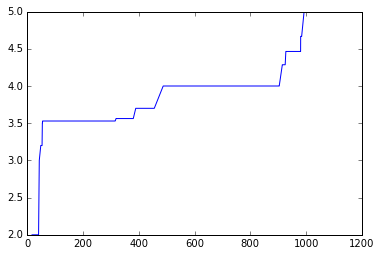

In [316]:
x = np.sort(subset[subset.Cat2=='Fairway'].Distance_from_hole.values)
y = Hole_Specific_Distance_Models['Fairway'].predict(x)
plt.plot(x,y)

In [322]:
if 'Residuals3' in subset.columns:
    subset = subset.drop('Residuals3',axis=1)
subset.insert(len(subset.columns),'Residuals3',subset.Shots_taken_from_location.values - subset.Predicted_shots_from_location_based_on_distance3)

In [323]:
np.corrcoef(subset.Residuals3.values,subset.Distance_from_hole.values)

array([[ 1.        , -0.02571414],
       [-0.02571414,  1.        ]])

In [324]:
xyz2 = pd.DataFrame({'x':subset.Started_at_X.values,'y':subset.Started_at_Y.values,'z':subset.Residuals3.values})

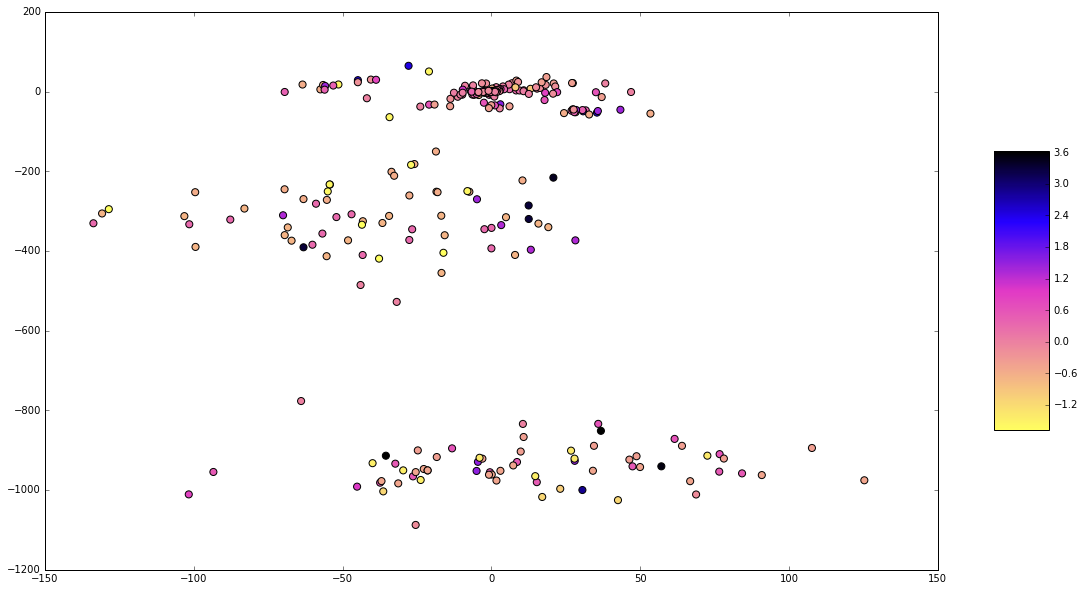

In [325]:
fig,ax = plt.subplots(figsize=(20, 10))
geo = geoplot.scatter( xyz2.x, xyz2.y, c=xyz2.z, cmap=geoplot.YPcmap,s=50 )
fig.colorbar(geo, shrink=0.5, aspect=5)

In [155]:
tolerance = 50
lags = np.arange( tolerance, 1000, tolerance*2 )
sill = np.var(xyz2.z)

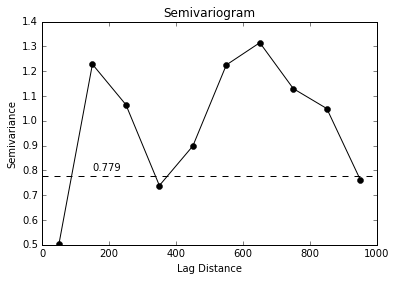

In [157]:
geoplot.semivariogram( xyz2.values, lags, tolerance )

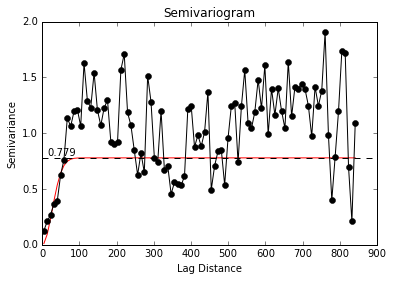

In [129]:
svm = model.semivariance( model.gaussian, ( 65, sill ) )
geoplot.semivariogram( xyz2.values, lags, tolerance, model=svm )

In [137]:
covfct = model.covariance( model.gaussian, ( 65, sill ) )

In [140]:
kriging.simple( xyz2.values, covfct, [-10,5], N=5 )

(1.201186805481027, 0.00075210411256771553)

In [141]:
kriging.ordinary(  xyz2.values, covfct, [-10,5], N=5  )

(1.2020242888480153, 0.00082754165950489178)

In [151]:
subset.Residuals2.describe()

count    2.980000e+02
mean    -4.940120e-16
std      8.840936e-01
min     -1.888889e+00
25%     -5.294118e-01
50%     -8.823529e-02
75%      2.964286e-01
max      3.714286e+00
Name: Residuals2, dtype: float64

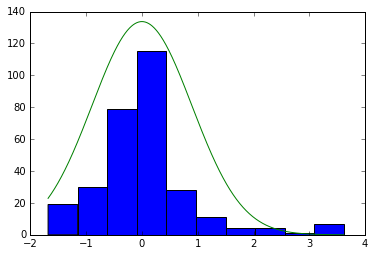

In [334]:
plt.hist(subset.Residuals3)
x = np.linspace(subset.Residuals3.min(), subset.Residuals3.max(), 1000)
plt.plot(x,300*mlab.normpdf(x, subset.Residuals3.mean(), subset.Residuals3.std()))
plt.show()

In [326]:
D = np.zeros((len(subset),len(subset)))
print D.shape
i1,i2 = 0,0
for index1,row1 in subset.iterrows():
    for index2,row2 in subset.iterrows():
        D[i1,i2] = ((row1.Started_at_X-row2.Started_at_X)**2 + (row1.Started_at_Y-row2.Started_at_Y)**2)**.5
        i2 += 1
    i1 +=1
    i2 = 0

(298, 298)


In [327]:
def corr(obs):
    obs0 = np.array([i[0] for i in obs])
    obsh = np.array([i[1] for i in obs])
    return np.corrcoef(obs0,obsh)[0][1]

def cov(obs):
    obs0 = np.array([i[0] for i in obs])
    obsh = np.array([i[1] for i in obs])
    return np.cov(obs0,obsh,ddof=0)[0][1]

def semiv(obs):
    obs0 = np.array([i[0] for i in obs])
    obsh = np.array([i[1] for i in obs])
    return 1/(2*float(len(obs))) * np.sum((obs0-obsh)**2)

In [328]:
np.amax(D)

1151.9474710342272

0
6
12
18
24
30
36
42
48
54
60
66
72
78
84
90
96
102
108
114
120
126
132
138
144
150
156
162
168
174
180
186
192
198
204
210
216
222
228
234
240
246
252
258
264
270
276
282
288
294
300
306
312
318
324
330
336
342
348
354
360
366
372
378
384
390
396
402
408
414
420
426
432
438
444
450
456
462
468
474
480
486
492
498
504
510
516
522
528
534
540
546
552
558
564
570
576
582
588
594
600
606
612
618
624
630
636
642
648
654
660
666
672
678
684
690
696
702
708
714
720
726
732
738
744
750
756
762
768
774
780
786
792
798
804
810
816
822
828
834
840
846
852
858
864
870
876
882
888
894
900
906
912
918
924
930
936
942
948
954
960
966
972
978
984
990
996
1002
1008
1014
1020
1026
1032
1038
1044
1050
1056
1062
1068
1074
1080
1086
1092
1098
1104
1110
1116
1122
1128
1134
1140
1146


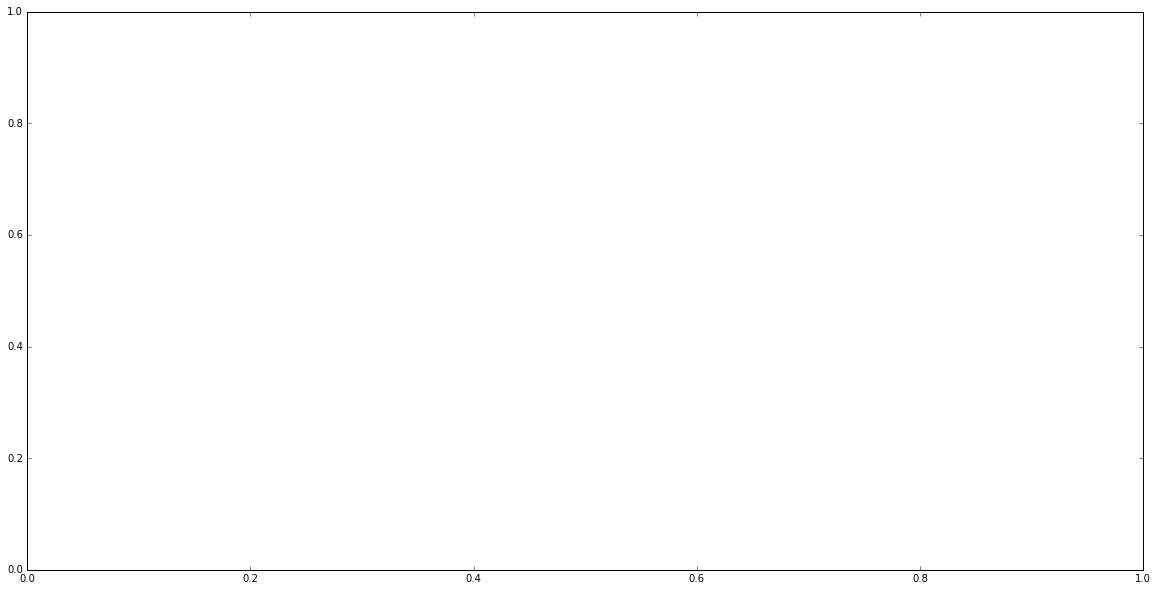

In [341]:
fig,ax = plt.subplots(figsize=(20, 10))
r = subset.Residuals3.values
l_t = 12
lag_tups = []
for lag in range(0,1150,6):
    print lag
    obs = []
    for inds in np.argwhere((D>lag-l_t) & (D<lag+l_t)):
        obs.append((r[inds[0]],r[inds[1]]))
    lag_tups.append((lag,corr(obs),cov(obs),semiv(obs)))

In [342]:
lag_tups

[(0, 0.19670797214848473, 0.033384756159774466, 0.13633259588823507),
 (6, 0.13577722849467627, 0.024822287423244941, 0.15799398963913608),
 (12, 0.0043898944824918747, 0.00079579587951316875, 0.18048324913786132),
 (18, -0.00064799842898289781, -0.00015497332863065753, 0.23931192448652872),
 (24, 0.0037637181157057177, 0.0011708553742333812, 0.30991922582698289),
 (30, 0.0041990056152149168, 0.0015207635758468904, 0.36065154939665028),
 (36, 0.0085907562114804006, 0.0035551472096357964, 0.41027887649188843),
 (42, -0.0015941891810003286, -0.0008272688193636746, 0.51975490251750289),
 (48, -0.0073339805397230244, -0.0043158934535551903, 0.59279488247991285),
 (54, -0.021914021503050392, -0.015663302140827132, 0.73042495091656023),
 (60, -0.02754046303534903, -0.022806386449062927, 0.85091107081076922),
 (66, -0.028125477028203932, -0.025525754707366923, 0.93309275105626388),
 (72, -0.034343185299480633, -0.036587068821480453, 1.1019241510528639),
 (78, -0.022026632385781921, -0.0243986

(0, 2.5)

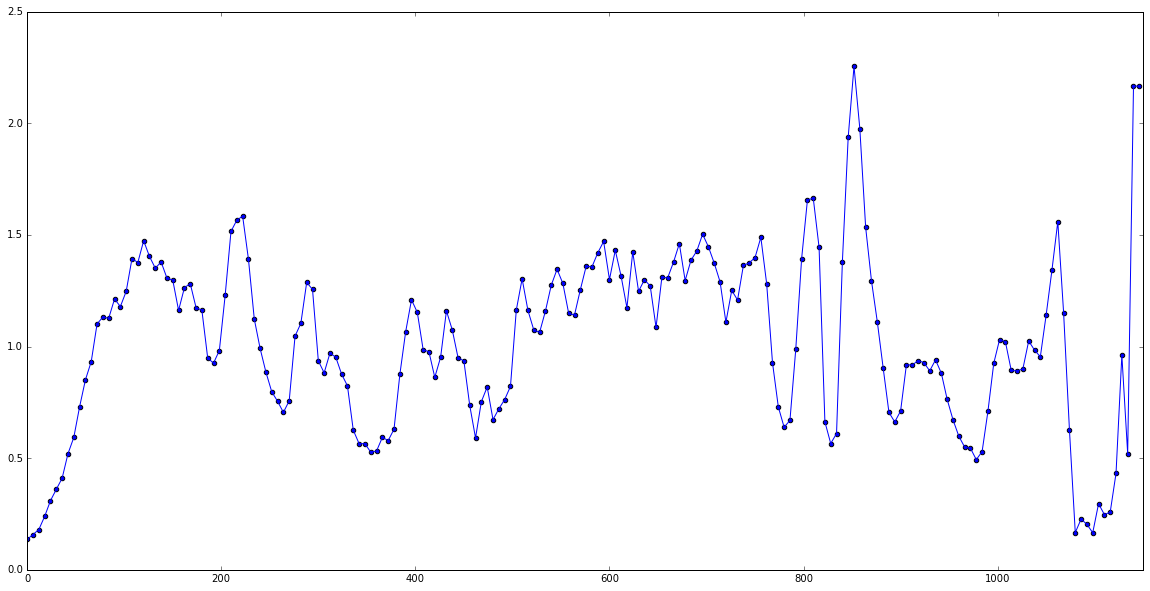

In [346]:
fig,ax = plt.subplots(figsize=(20, 10))
lag_ = [tup[0] for tup in lag_tups]
corr_ = [tup[1] for tup in lag_tups]
cov_ = [tup[2] for tup in lag_tups]
sv_ = [tup[3] for tup in lag_tups]
plt.scatter(lag_,sv_)
#plt.scatter(lag_,cov_)
#plt.scatter(lag_,corr_)
plt.plot(lag_,sv_)
#plt.plot(lag_,cov_)
#plt.plot(lag_,corr_)
ax.set_xlim([0,1150])
ax.set_ylim([0,2.5])

In [336]:
np.var(subset.Residuals3.values)

0.79811167459352717